In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Loading and Combining the datasets

In [2]:
# Loading the separate datasets
red = pd.read_csv('Data/Real_Datasets/winequality-red.csv', sep=';')
white = pd.read_csv('Data/Real_Datasets/winequality-white.csv', sep=';')

# Adding a 'type' column to distinguish between red and white wines
red['type'] = 'red'
white['type'] = 'white'

# Combining datasets
wine_df = pd.concat([red, white], ignore_index=True)

# Displaying the shape of the combined dataset
print(wine_df.shape)  

#saving the combined unprocessed dataset
wine_df.to_csv("Data/Real_Datasets/wine_unprocessed.csv", index=False)

(6497, 13)


Unprocessed Data exploration

In [3]:
print(wine_df.head())

print(wine_df.dtypes)

# Get summary statistics
print(wine_df.describe())

# Checking for missing values
print(wine_df.isnull().sum())

# Cheking for duplicates
duplicates_with_type = wine_df.duplicated().sum()
print(f"Duplicates including 'type': {duplicates_with_type}")

# Count duplicates excluding 'type'
duplicates_wo_type = wine_df.drop(columns=['type'], errors='ignore').duplicated().sum()
print(f"Duplicates excluding 'type': {duplicates_wo_type}")

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality type  
0      9.4        5  red  
1      9.8        5  red  
2    

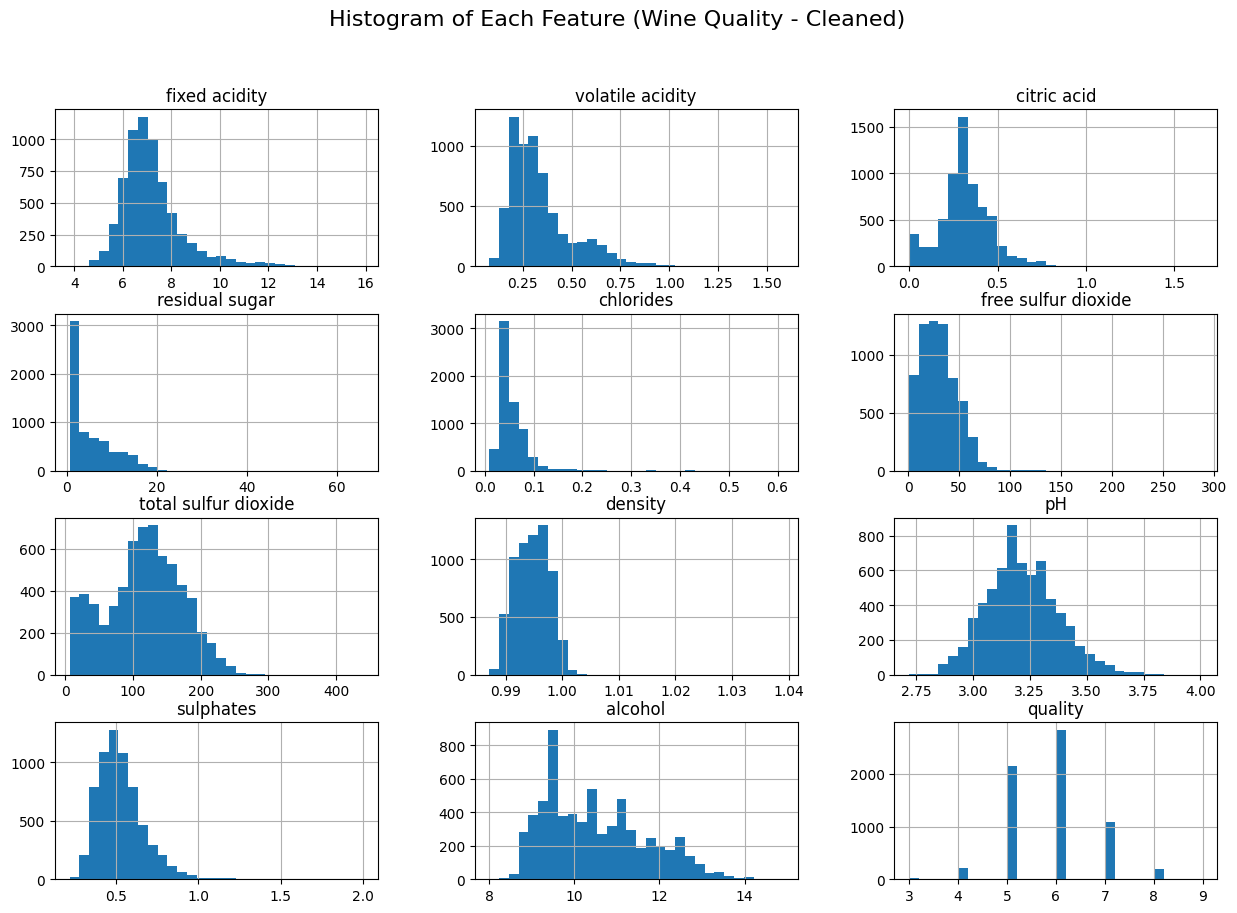

In [4]:
# Visual check for normality
wine_df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogram of Each Feature (Wine Quality - Cleaned)", fontsize=16)
plt.show()

Scaling and Normalizing
As shown in the histograms, not all the features are normally distributed. The only feature that is close to bell-shaped is PH. Quality, citric acid, alcohol, fixed acidity, density and Sulphates are moderately skewed. The rest of the features are heavily right-skewed and not normal, including residual sugar which is very skewed, chlorides, free sulfur dioxide, total sulfur dioxide, volatile acidity. Since Pearson correlation assumes that the data is normally distributed, the heavily skewed columns are transformed by np.log1p(), which reduces the right-skewness. Then we apply Standardization to all of the features which works better for roughly normal data.  

In [5]:
skewed_cols = [
    'residual sugar', 'chlorides', 'free sulfur dioxide',
    'total sulfur dioxide', 'volatile acidity'
]

for col in skewed_cols:
    wine_df[col] = np.log1p(wine_df[col])


In [6]:
from sklearn.preprocessing import StandardScaler

numeric_cols = wine_df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
wine_df[numeric_cols] = scaler.fit_transform(wine_df[numeric_cols])

print(wine_df.describe().T[['mean', 'std']])


                              mean       std
fixed acidity        -3.849639e-16  1.000077
volatile acidity      1.749836e-16  1.000077
citric acid           2.187295e-17  1.000077
residual sugar        3.499672e-17  1.000077
chlorides             0.000000e+00  1.000077
free sulfur dioxide  -1.749836e-16  1.000077
total sulfur dioxide  6.299409e-16  1.000077
density              -3.552167e-15  1.000077
pH                    2.729744e-15  1.000077
sulphates            -5.424491e-16  1.000077
alcohol               9.974065e-16  1.000077
quality              -3.105959e-16  1.000077


Histogram after scaling

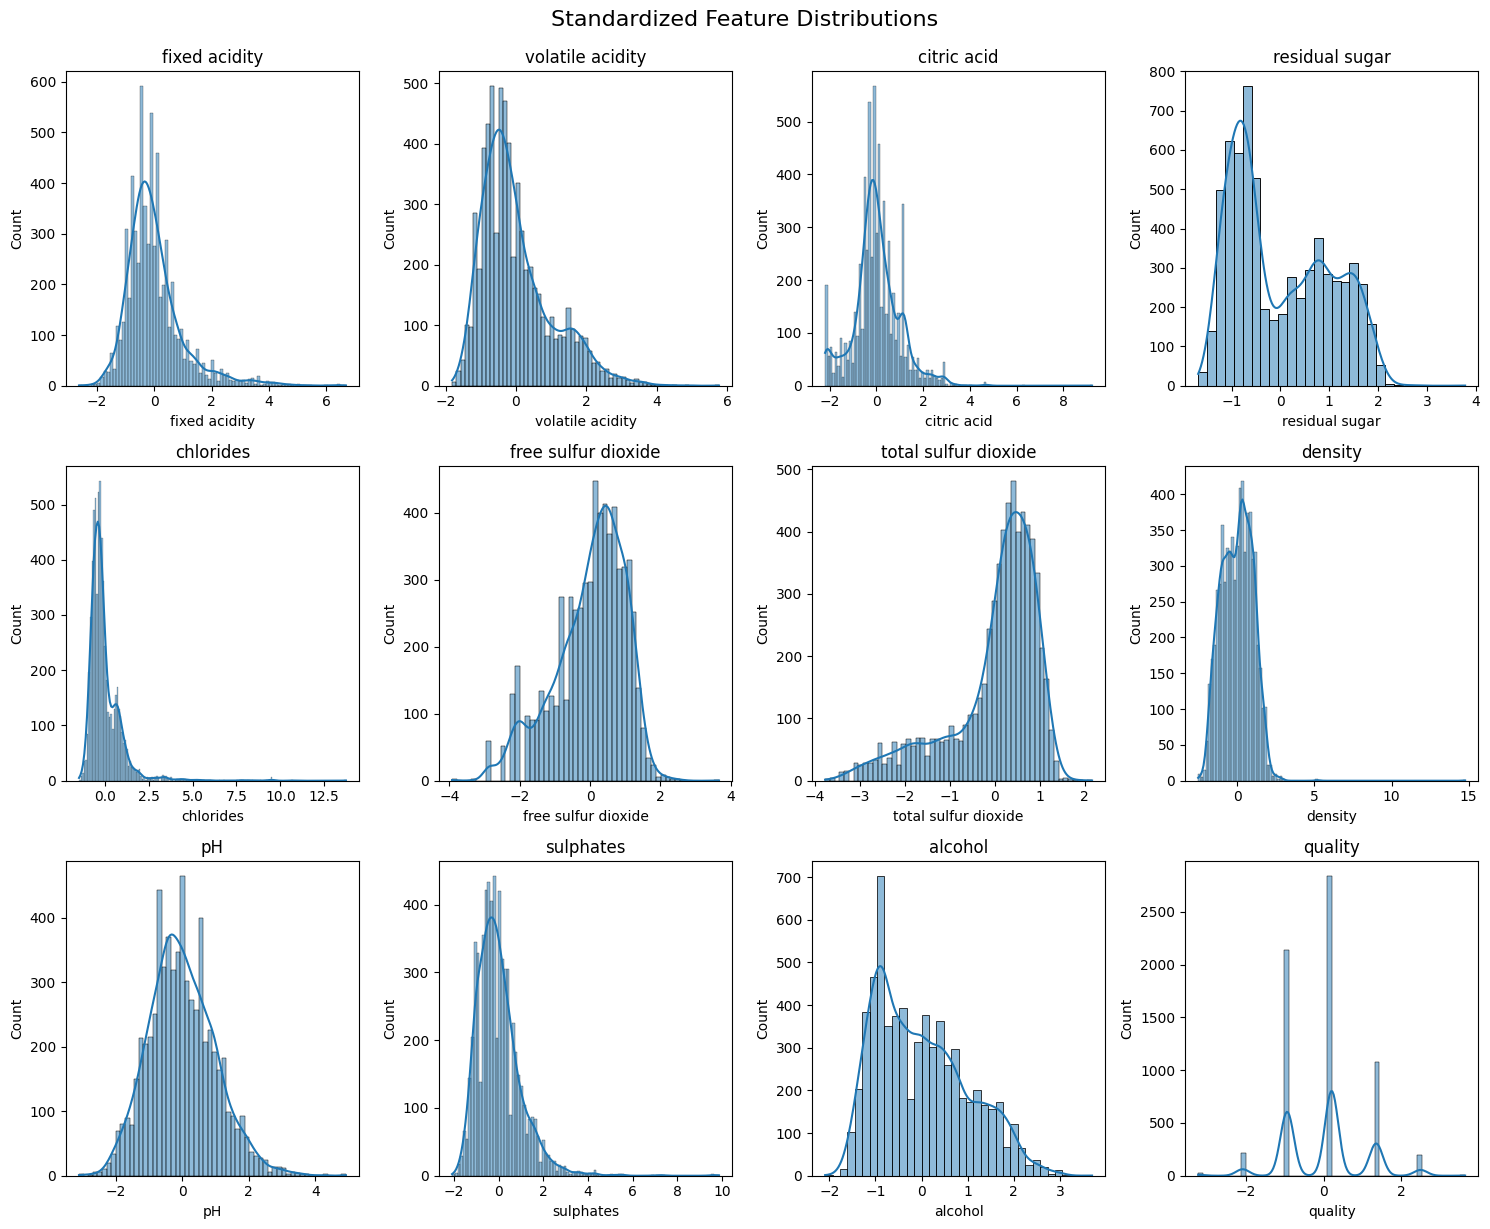

In [7]:
numeric_cols = wine_df.select_dtypes(include=['float64', 'int64']).columns
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # auto-calculate rows

plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(wine_df[col], kde=True)
    plt.title(f"{col}")
    plt.tight_layout()

plt.suptitle("Standardized Feature Distributions", fontsize=16, y=1.02)
plt.show()

In [8]:
#saving the processed dataset
wine_df.to_csv("Data/Real_Datasets/wine_processed.csv", index=False)

In [19]:
wine_df = wine_df.drop_duplicates(subset=[col for col in wine_df.columns if col != "type"])
print(f"Wine dataset without Duplicates : {wine_df.shape[0]}")

#saving the deduplicated processed dataset
wine_df.to_csv("Data/Real_Datasets/wine_processed_dedu.csv", index=False)

Wine dataset without Duplicates : 5318


In [20]:
#loading the unprocessed dataset to deduplicate before comparison
wine_df_org = pd.read_csv("Data/Real_Datasets/wine_unprocessed.csv")

wine_df_org = wine_df_org.drop_duplicates(subset=[col for col in wine_df_org.columns if col != "type"])
print(f"raw wine dataset without Duplicates : {wine_df_org.shape[0]}")


raw wine dataset without Duplicates : 5318


Comparing the Pearson and Spearman correlations for processed and unprocessed data

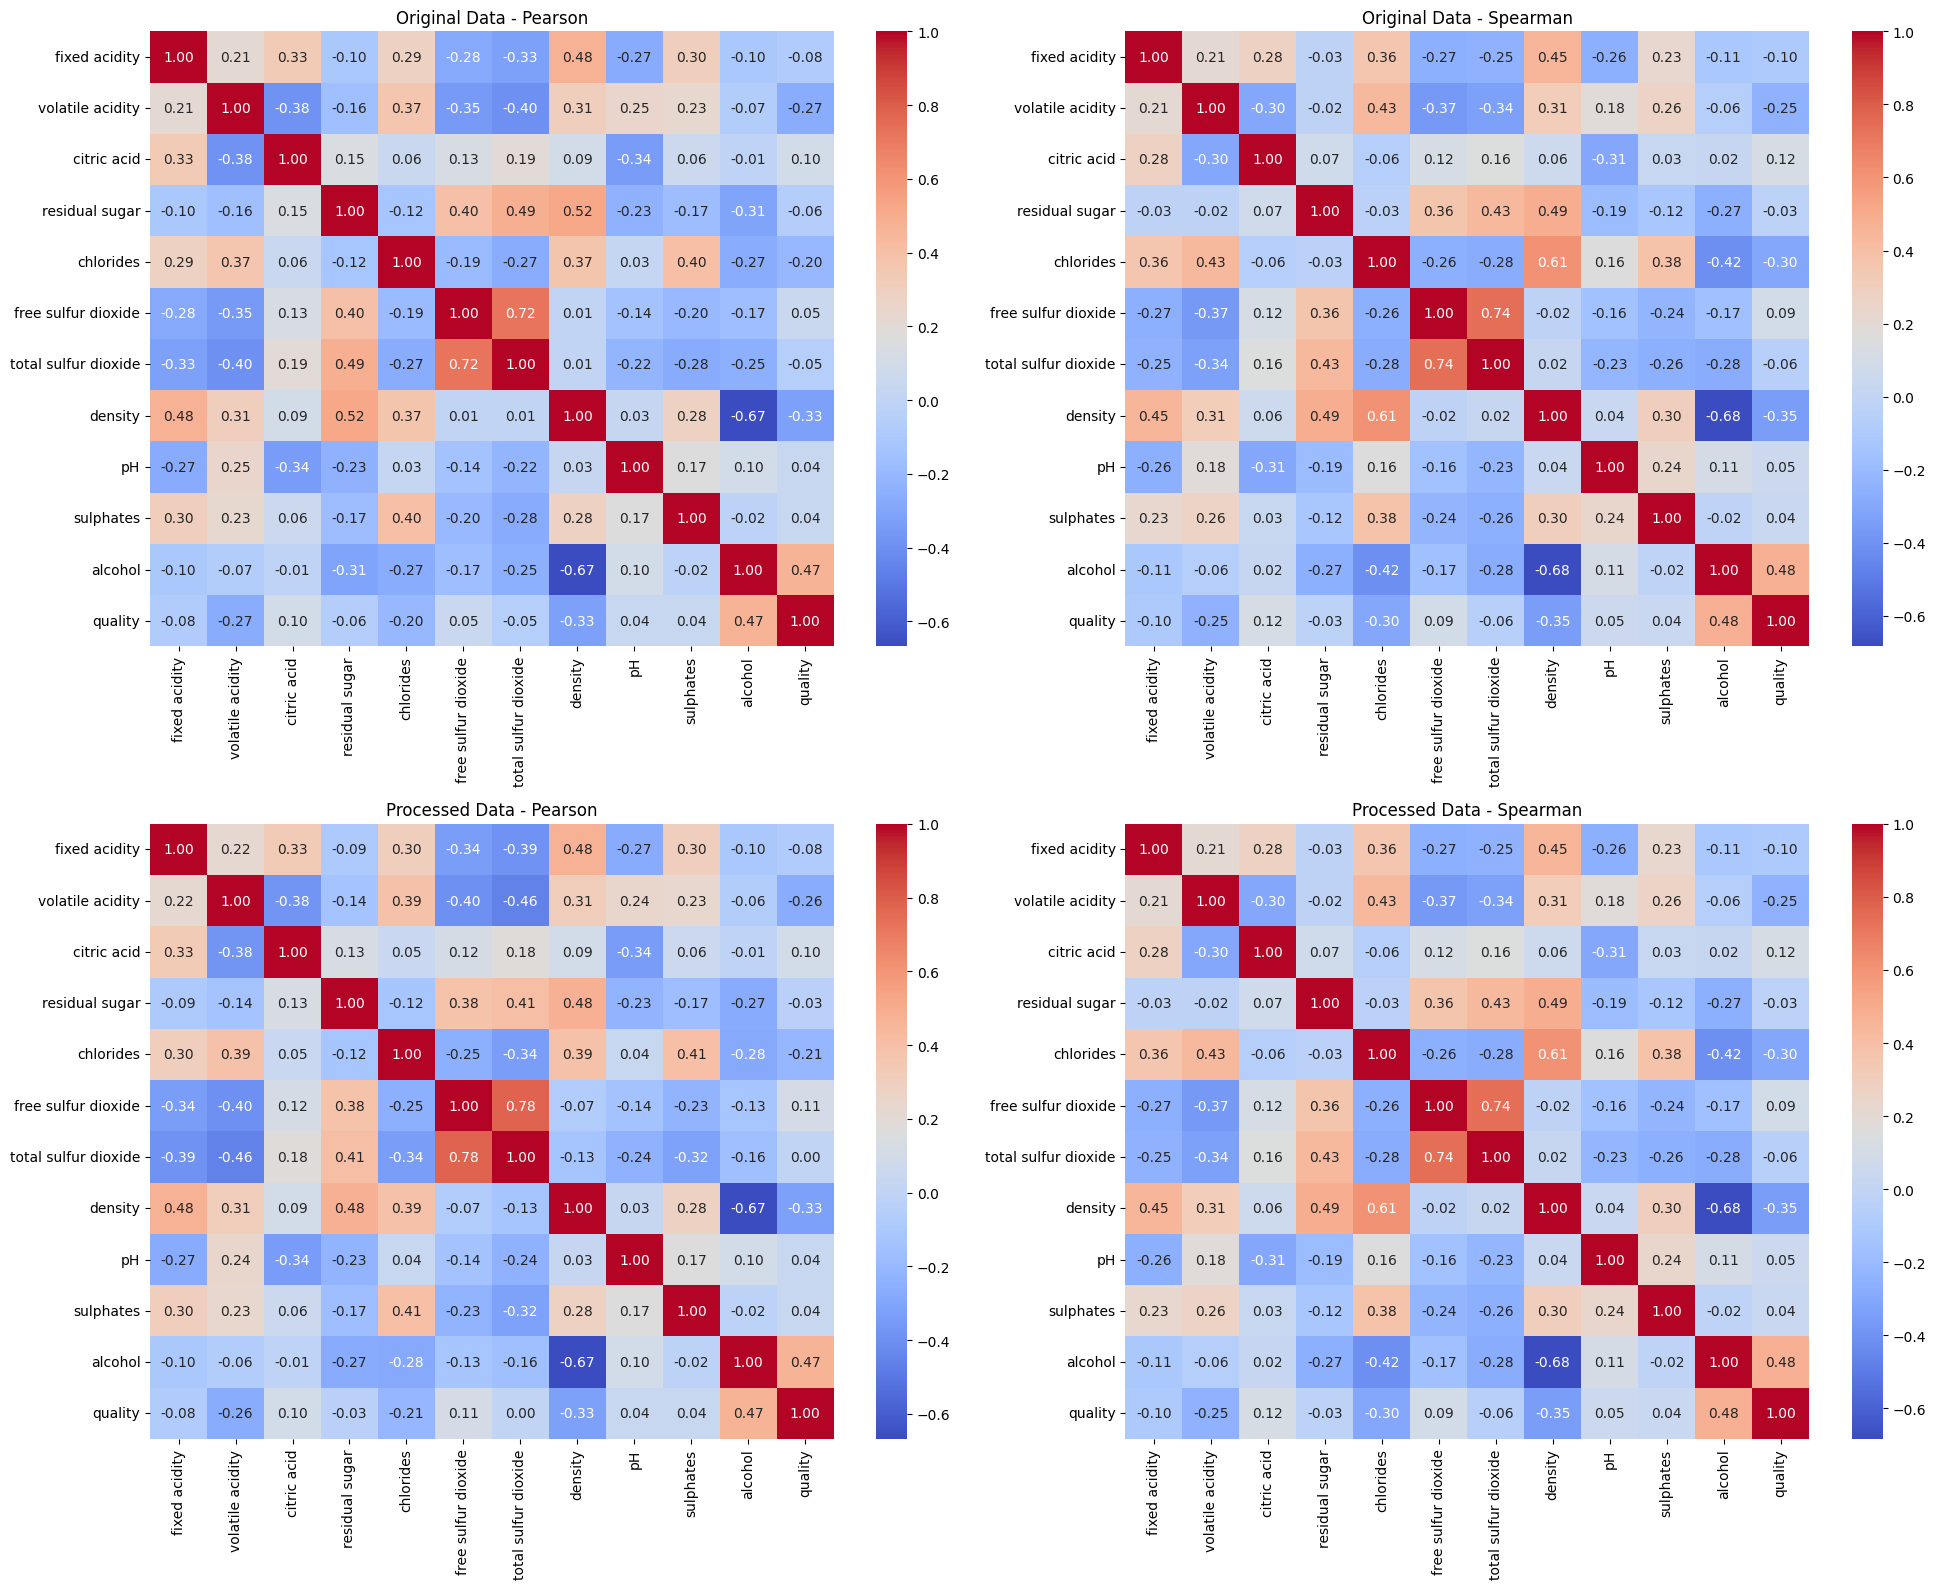

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Original data
num_org = wine_df_org.select_dtypes(include=['float64', 'int64'])
pearson_org = num_org.corr(method='pearson')
spearman_org = num_org.corr(method='spearman')

# Processed
num_proc = wine_df.select_dtypes(include=['float64', 'int64'])
pearson_proc = num_proc.corr(method='pearson')
spearman_proc = num_proc.corr(method='spearman')

# Plotting 
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Raw - Pearson
sns.heatmap(pearson_org, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0, 0])
axes[0, 0].set_title("Original Data - Pearson")

# Raw - Spearman
sns.heatmap(spearman_org, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("Original Data - Spearman")

# Processed - Pearson
sns.heatmap(pearson_proc, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1, 0])
axes[1, 0].set_title("Processed Data - Pearson")

# Processed - Spearman
sns.heatmap(spearman_proc, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1, 1])
axes[1, 1].set_title("Processed Data - Spearman")

plt.tight_layout()
plt.show()


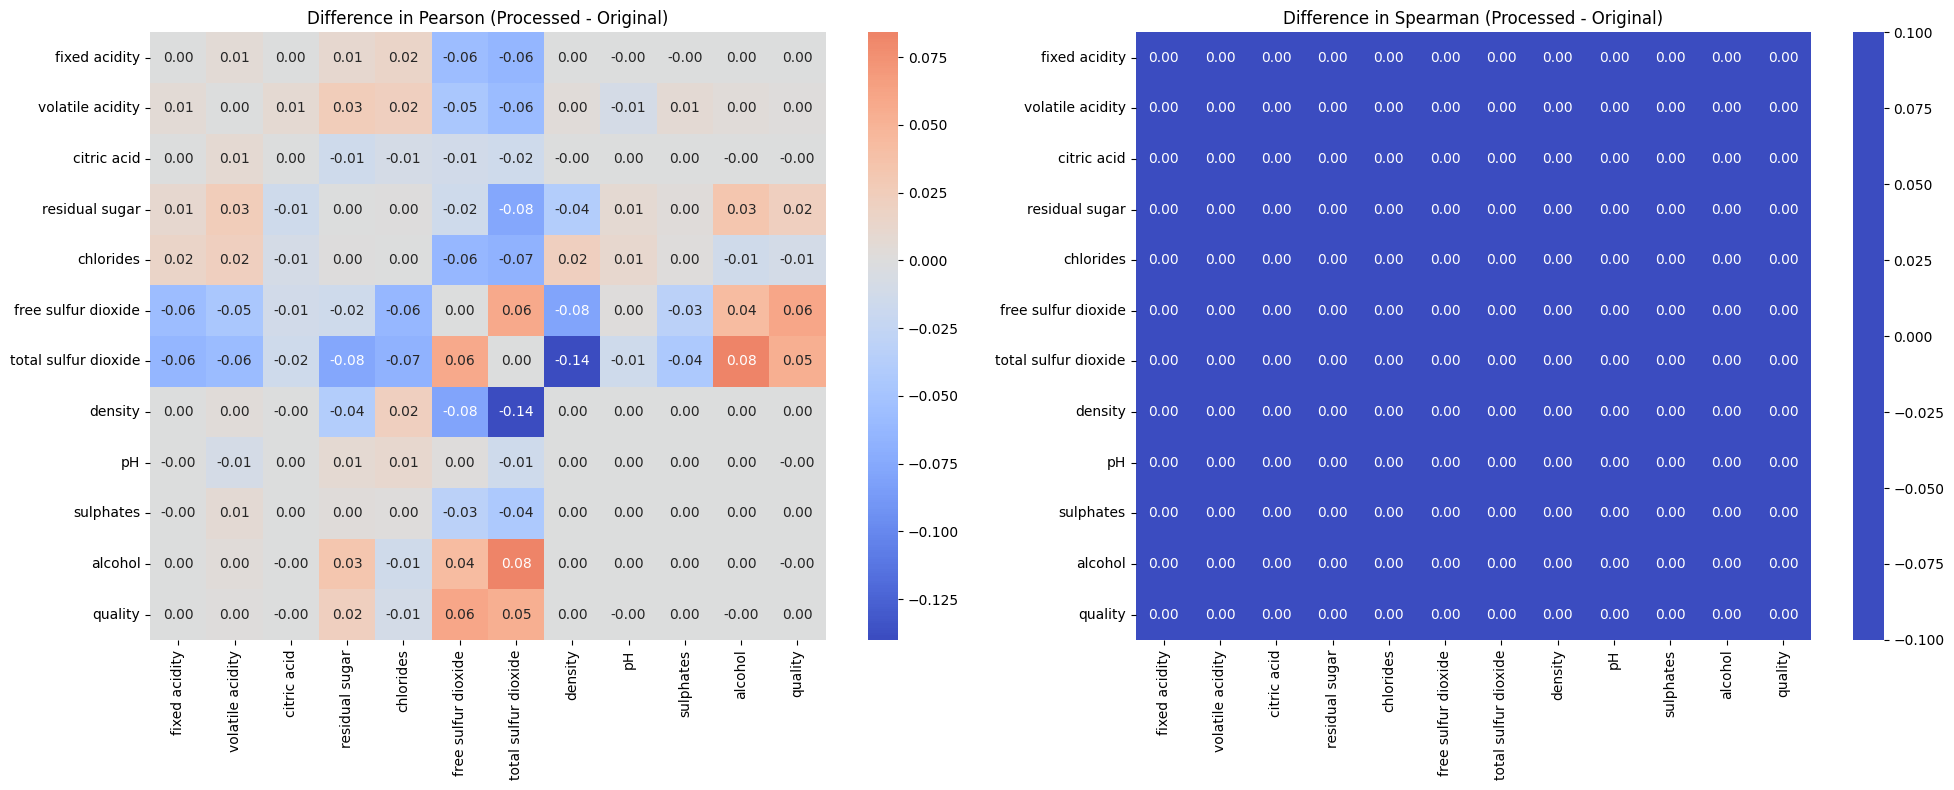

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Raw/Original
num_org = wine_df_org.select_dtypes(include=['float64', 'int64'])
pearson_org = num_org.corr(method='pearson')
spearman_org = num_org.corr(method='spearman')

# Processed 
num_proc = wine_df.select_dtypes(include=['float64', 'int64'])
pearson_proc = num_proc.corr(method='pearson')
spearman_proc = num_proc.corr(method='spearman')

# Differences (Processed - Original)
pearson_diff = pearson_proc - pearson_org
spearman_diff = spearman_proc - spearman_org

# Plot 
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(pearson_diff, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Difference in Pearson (Processed - Original)")

sns.heatmap(spearman_diff, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Difference in Spearman (Processed - Original)")

plt.tight_layout()
plt.show()


distance corelation for both data sets

In [13]:
import numpy as np

# Step 1: fast distance covariance
def fast_dcov(x, y):
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    n = len(x)
    
    # Sort x
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    
    # Row sums of distance matrix of x
    si = np.cumsum(x)
    s = si[-1]
    ax = (-(n-2) + 2*np.arange(n)) * x + (s - 2*si)
    
    # Weight matrix
    v = np.column_stack((x, y, x*y))
    nw = v.shape[1]
    
    idx_buf = np.zeros((n, 2), dtype=int)
    idx_buf[:, 0] = np.arange(n)
    
    iv1 = np.zeros(n)
    iv2 = np.zeros(n)
    iv3 = np.zeros(n)
    iv4 = np.zeros(n)
    
    i = 1
    r, s_idx = 0, 1
    while i < n:
        gap = 2 * i
        k = 0
        idxr = idx_buf[:, r]
        csumv = np.vstack([np.zeros((1, nw)), np.cumsum(v[idxr], axis=0)])
        
        for j in range(0, n, gap):
            st1 = j
            e1 = min(st1 + i - 1, n-1)
            st2 = j + i
            e2 = min(st2 + i - 1, n-1)
            
            while st1 <= e1 and st2 <= e2:
                idx1 = idxr[st1]
                idx2 = idxr[st2]
                if y[idx1] >= y[idx2]:
                    idx_buf[k, s_idx] = idx1
                    st1 += 1
                else:
                    idx_buf[k, s_idx] = idx2
                    iv1[idx2] += e1 - st1 + 1
                    iv2[idx2] += csumv[e1+1, 0] - csumv[st1, 0]
                    iv3[idx2] += csumv[e1+1, 1] - csumv[st1, 1]
                    iv4[idx2] += csumv[e1+1, 2] - csumv[st1, 2]
                    st2 += 1
                k += 1
            
            # Copy leftovers
            if st1 <= e1:
                idx_buf[k:k+e1-st1+1, s_idx] = idxr[st1:e1+1]
                k += e1-st1+1
            elif st2 <= e2:
                idx_buf[k:k+e2-st2+1, s_idx] = idxr[st2:e2+1]
                k += e2-st2+1
                
        i = gap
        r, s_idx = s_idx, r
    
    covterm = n * np.sum((x - np.mean(x)) * (y - np.mean(y)))
    c1 = np.dot(iv1, v[:, 2])
    c2 = np.sum(iv4)
    c3 = np.dot(iv2, y)
    c4 = np.dot(iv3, x)
    d = 4 * ((c1 + c2) - (c3 + c4)) - 2 * covterm
    
    ySorted = y[idx_buf[n-1::-1, r]]
    si_y = np.cumsum(ySorted)
    s_y = si_y[-1]
    by = np.zeros(n)
    by[idx_buf[n-1::-1, r]] = (-(n-2) + 2*np.arange(n)) * ySorted + (s_y - 2*si_y)
    
    nsq = n * n
    ncb = nsq * n
    nq = ncb * n
    term1 = d / nsq
    term2 = 2 * np.dot(ax, by) / ncb
    term3 = np.sum(ax) * np.sum(by) / nq
    
    covsq = (term1 + term3) - term2
    return covsq

# Step 2: distance correlation matrix for tabular data
def distance_correlation_matrix(data):
    data = np.asarray(data)
    n_features = data.shape[1]
    dcor_mat = np.zeros((n_features, n_features))

    for i in range(n_features):
        for j in range(i, n_features):
            x = data[:, i]
            y = data[:, j]
            dcov_xy = fast_dcov(x, y)
            dcov_xx = fast_dcov(x, x)
            dcov_yy = fast_dcov(y, y)
            dcor = np.sqrt(dcov_xy / np.sqrt(dcov_xx * dcov_yy)) if dcov_xx > 0 and dcov_yy > 0 else 0
            dcor_mat[i, j] = dcor
            dcor_mat[j, i] = dcor

    return dcor_mat


In [14]:
num_org = wine_df_org.select_dtypes(include=np.number)
dcor_org = distance_correlation_matrix(num_org.values)
num_processed = wine_df.select_dtypes(include=np.number)
dcor_processed = distance_correlation_matrix(num_processed.values)

In [15]:
num_org = wine_df_org.select_dtypes(include=np.number)
dcor_org = pd.DataFrame(
    distance_correlation_matrix(num_org.values),
    index=num_org.columns,
    columns=num_org.columns
)

num_processed = wine_df.select_dtypes(include=np.number)
dcor_processed = pd.DataFrame(
    distance_correlation_matrix(num_processed.values),
    index=num_processed.columns,
    columns=num_processed.columns
)

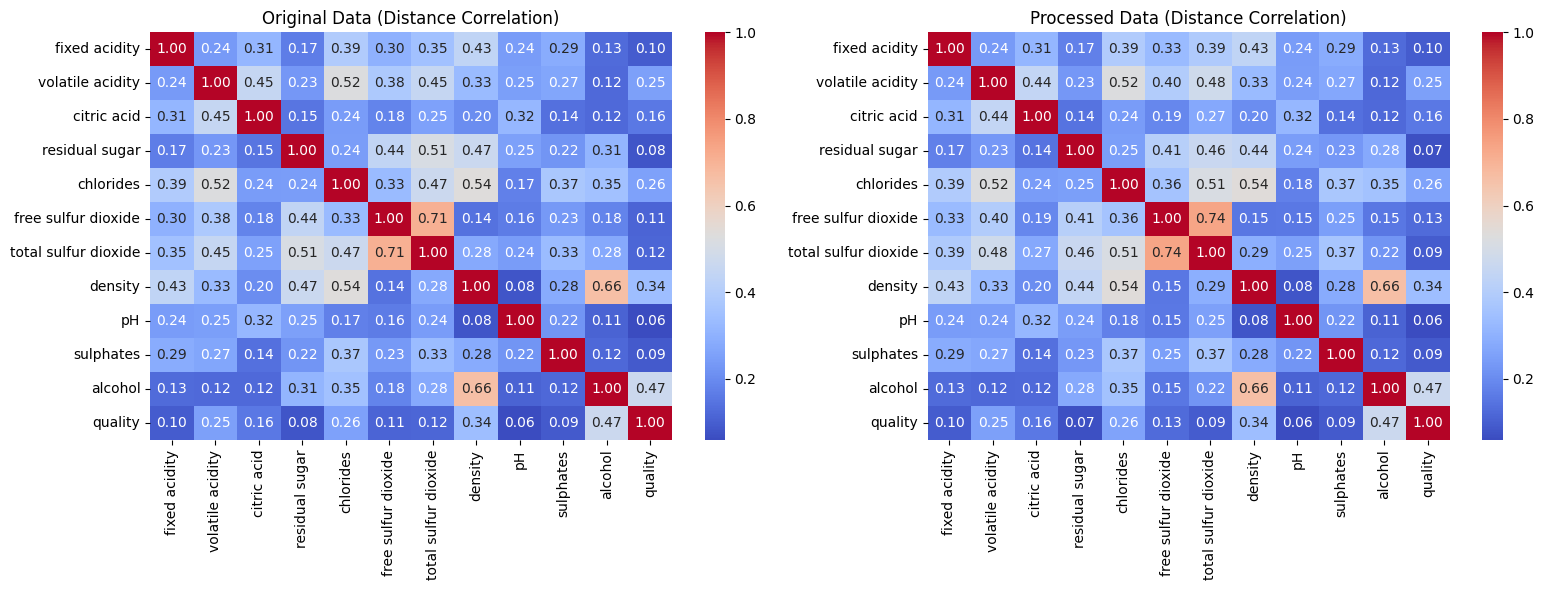

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(dcor_org, ax=axes[0], cmap="coolwarm", annot=True, fmt=".2f")
axes[0].set_title("Original Data (Distance Correlation)")

sns.heatmap(dcor_processed, ax=axes[1], cmap="coolwarm", annot=True, fmt=".2f")
axes[1].set_title("Processed Data (Distance Correlation)")

plt.tight_layout()
plt.show()

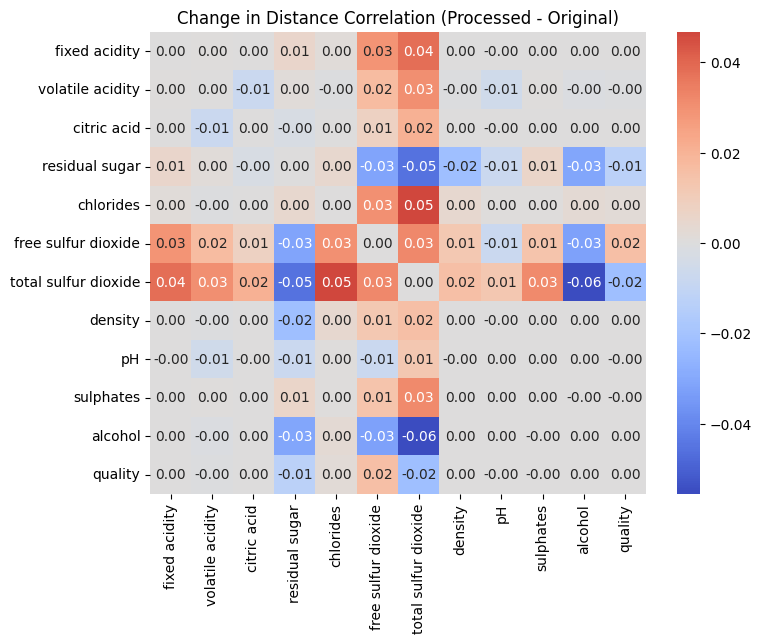

In [17]:
diff_dcor = dcor_processed - dcor_org

plt.figure(figsize=(8, 6))
sns.heatmap(diff_dcor, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Change in Distance Correlation (Processed - Original)")
plt.show()